In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
import sys
my_local_drive='/content/gdrive/MyDrive/ML2_projet'
sys.path.append(my_local_drive)

In [16]:
%cd $my_local_drive

/content/gdrive/MyDrive/ML2_projet


In [17]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path

from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
# Classes à utiliser pour la partie classification de texte. Laquelle ?
  ## --> pratique si on récupère le premier token 'CLS' style
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads,ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
              TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
def plot_history_simple(history):
    """
    Trace côte à côte les courbes Loss et Accuracy (train/val si dispo)
    à partir d'un objet Keras History.
    """
    hist = history.history

    # compatibilité anciennes versions ("acc"/"val_acc")
    acc_key = "accuracy" if "accuracy" in hist else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Loss ---
    if "loss" in hist:
        axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if acc_key in hist:
        axes[1].plot(hist[acc_key], label="train")
        if val_acc_key in hist:
            axes[1].plot(hist[val_acc_key], label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()
    else:
        axes[1].set_visible(False)  # si pas d'accuracy, on masque le 2e plot

    plt.tight_layout()
    plt.show()


In [19]:
# Répertoire cible pour sauvegarder vos modèles
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

# Répertoire des données
dataset_dir = "./flickr_subset2"

# Répertoire des images
image_dir = os.path.join(dataset_dir, "images")
# Répertoire des captions
captions_dir = os.path.join(dataset_dir, "captions")

# Variables utiles
# Attention respecter bien l'ordre alphabétique des classes pour
# le générateur
class_names = ['ball', 'bike', 'dog', 'water']
# class encoding dict
class_dict = {
    "ball": 0,
    "bike": 1,
    "dog": 2,
    "water": 3
}
# Pour les images
image_size=(224, 224)
image_shape = image_size + (3,)

# Pour les textes
sequence_length = 32
vocab_size = 10000
num_heads = 4
ff_dim = 256
num_layers = 2

# Pour les images et les textes dans le modèle CLIP
embed_dim = 128

# pour le training:
batch_size = 16

# LOAD DATA

In [20]:
caption_file_path = Path(dataset_dir) / "captions.csv"
captions_df = pd.read_csv(caption_file_path, sep=",")
captions_df.head()

,image_path,label,caption
0,images/dog/dog_001.jpg,dog,A black dog and a spotted dog are fighting
1,images/dog/dog_002.jpg,dog,A man lays on a bench while his dog sits by him .
2,images/dog/dog_003.jpg,dog,A black and white dog is running in a grassy g...
3,images/dog/dog_004.jpg,dog,"A dog shakes its head near the shore , a red b..."
4,images/dog/dog_005.jpg,dog,A black dog leaps over a log .


# Train test split

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
X = captions_df['caption'].to_numpy()

# encode class to int values and convert to nd array
y = captions_df['label'].apply(lambda x: class_dict[x]).to_numpy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X.shape, X_train.shape, X_temp.shape, X_val.shape, X_test.shape

((600,), (480,), (120,), (60,), (60,))

# Tokenize

In [23]:
@dataclass
class Preprocessor:
    vocab_size: int
    sequence_length: int
    padding: bool = True
    batch_size: int = 16

    def __post_init__(self):
      self.is_initialized: bool = False
      # build tokenizer from params
      self.tokenizer = TextVectorization(
        max_tokens=vocab_size,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        pad_to_max_tokens=self.padding,
        output_sequence_length=sequence_length,
        output_mode="int"  # save 0 for pad tokens
      )


    def fit_preprocessor(self, X_train: np.ndarray) -> None:
      # fit the preprocessor with the text
      self.tokenizer.adapt(X_train)
      self.is_initialized = True
      print("There are", len(self.tokenizer.get_vocabulary()), "tokens in the vocabulary")


    def process(self, X: np.ndarray, y: np.ndarray, shuffle=False) -> tf.data.Dataset:
      # Returns a tf.data.Dataset for batch processing

      if not self.is_initialized:
        raise ValueError("Preprocessor is not initialized. Call fit_preprocessor first.")

      token_ids = self.tokenizer(X)

      # force type to avoid issues
      y_onehot = to_categorical(y, num_classes=len(class_names))


      ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": token_ids},
        y_onehot
      ))
      if shuffle:
          ds = ds.shuffle(buffer_size=y_onehot.shape[0], seed=42)

      return ds.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

In [25]:
# PREPROCESSING TEXT DATA

# init
preprocessor = Preprocessor(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    padding=True,
    batch_size=batch_size
)

# fit train data
preprocessor.fit_preprocessor(X_train)

# get dataset
ds_train = preprocessor.process(X_train, y_train, shuffle=True)
ds_test = preprocessor.process(X_test, y_test)
ds_val = preprocessor.process(X_val, y_val)

There are 843 tokens in the vocabulary


# BUILD MODEL

In [45]:
def build_smallbert_classifier(
    sequence_length=sequence_length,
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    training: bool=False):
  # inputs (no need for attention mask as they will be determined by the bert model)
  ids  = layers.Input(shape=(sequence_length,), dtype="int32", name="input_ids")
  # base model
  base_model = SmallBERT(
      sequence_length=sequence_length,
      vocab_size=vocab_size,
      embed_dim=embed_dim,
      num_heads=num_heads,
      ff_dim=ff_dim,
      num_layers=num_layers
  )(ids)
  # how to compress information to a single vector
  representative_vectors = MaskedMean()((base_model, ids))

  # classification head
  # Remove one class because one hot encoded
  logits = keras.layers.Dense(len(class_names), activation="softmax")(representative_vectors)

  # final model
  final_model = keras.Model(inputs=ids, outputs=logits, name="smallbert_classif")
  final_model.summary()
  final_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss="categorical_crossentropy",
      metrics=[
          keras.metrics.CategoricalAccuracy(name="accuracy"),
          keras.metrics.F1Score(average="macro", name="f1score"),
      ]
    )
  return final_model

# TRAIN MODEL

In [46]:
data_config = {
    "sequence_length":sequence_length,
    "vocab_size":vocab_size,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "ff_dim":ff_dim,
    "num_layers":num_layers,
    "training":True
}

model = build_smallbert_classifier(**data_config)
save_dir = model_dir
name_model = "first_test_classif_smallbert.weights.h5"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, name_model)

callbacks = [
    EarlyStopping(monitor="f1score", mode="max", patience=2,
                  restore_best_weights=True),
    ModelCheckpoint(model_path, monitor="f1score", mode="max",
                    save_best_only=True, save_weights_only=True)
]

epochs=10
history=model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks)

Model: "smallbert_classif"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ small_bert_7        │ (None, 32, 128)   │  1,944,832 │ input_ids[0][0]   │
│ (SmallBERT)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_mean_2       │ (None, 128)       │          0 │ small_bert_7[0][… │
│ (MaskedMean)        │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 4)         │        516 │ masked_mean_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,945,348 (7.42 MB)

 Trainable params: 1,945,348 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_ids
Received: inputs=['Tensor(shape=(None, 32))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'masked_mean_2' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.2625 - f1score: 0.2459 - loss: 1.4364 - val_accuracy: 0.3167 - val_f1score: 0.2997 - val_loss: 1.2489
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5404 - f1score: 0.5198 - loss: 1.1410 - val_accuracy: 0.5167 - val_f1score: 0.4838 - val_loss: 1.1259
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7456 - f1score: 0.7409 - loss: 0.8594 - val_accuracy: 0.5500 - val_f1score: 0.5575 - val_loss: 0.9793
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.7799 - f1score: 0.7789 - loss: 0.7209 - val_accuracy: 0.6167 - val_f1score: 0.5987 - val_loss: 0.8738
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8314 - f1score: 0.8275 - loss: 0.5019 - val_accuracy: 0.6333 - val_f1score: 0.6164 - val_loss: 0.9209
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9285 - f1score: 0.9263 - loss: 0.3441 - val_accuracy: 0.6833 - val_f1score: 0.6752 - val_loss: 1.0170
Ep

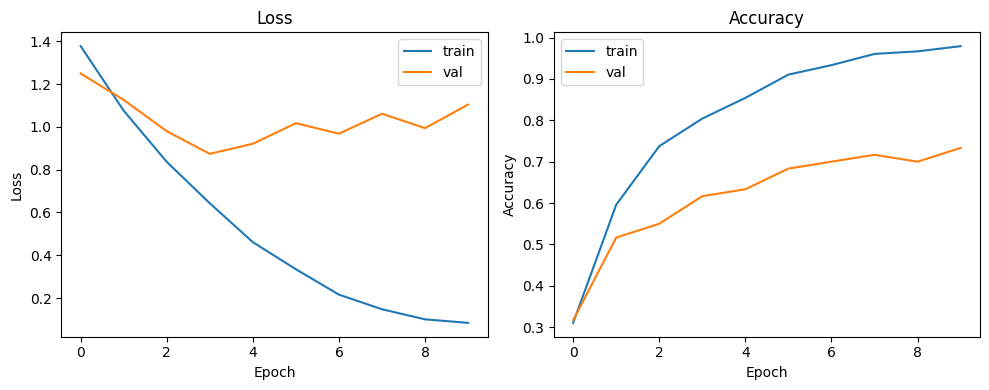

In [47]:
plot_history_simple(history)